<a href="https://colab.research.google.com/github/eutiagovski/amex-default-predicition/blob/main/model-selection/Amex_Default_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mljar-supervised

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 4.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
     |████████████████████████████████| 192.9 MB 61 kB/s 
     |████████████████████████████████| 2.0 MB 34.4 MB/s 
     |████████████████████████████████| 76.6 MB 1.4 MB/s 
     |████████████████████████████████| 61 kB 251 kB/s 
     |████████████████████████████████| 319 kB 44.8 MB/s 
     |████████████████████████████████| 366 kB 48.0 MB/s 
     |████████████████████████████████| 69 kB 7.7 MB/s 
     |████████████████████████████████| 308 kB 52.3 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 52.7 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 112 kB 48.3 MB/s 
     |████████████████████████████████| 146 kB 41.6 MB/s 
     |████████████████████████████████| 

In [2]:
# imports

import os
import gc
import glob
import tqdm
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from supervised.automl import AutoML # mljar-supervised

from sklearn.model_selection import train_test_split

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [3]:
# load data

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)

train_labels = pd.read_csv('/content/drive/MyDrive/kaggle/amex-default-predict/train_labels.csv')
train_labels['customer_ID'] = train_labels['customer_ID'].apply(lambda x: int(x[-16:], 16)).astype(np.int64)
train_labels = train_labels.set_axis(train_labels['customer_ID'])
train_labels = train_labels.drop(['customer_ID'], axis=1)

train_pkls = sorted(glob.glob('/content/drive/MyDrive/kaggle/amex-default-predict/train_data_*'))
train_y = sorted(glob.glob('/content/drive/MyDrive/kaggle/amex-default-predict/train_y_*.npy'))

train_df = pd.read_pickle(train_pkls[0])
df_features = pd.read_pickle('/content/drive/MyDrive/kaggle/amex-default-predict/XGB_model_0.7790193265518999_feature_importance.pkl')



In [ ]:
# prepare train data

train_df = train_pkls[0]
for i in train_pkls[1:]:
    print(i)
    train_df = train_df.append(pd.read_pickle(i))
    gc.collect()
    
y = train_labels.loc[train_df.index.values].values.astype(np.int8)

X_train, X_val, y_train, y_val = train_test_split(train_df, y,
                                                    stratify=y, 
                                                    test_size=0.20,
                                                    random_state=SEED)
print(train_df.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del train_df, y
gc.collect()

/content/drive/MyDrive/kaggle/amex-default-predict/train_data_1.pkl
/content/drive/MyDrive/kaggle/amex-default-predict/train_data_2.pkl
/content/drive/MyDrive/kaggle/amex-default-predict/train_data_3.pkl
(458913, 1293) (367130, 1293) (91783, 1293) (367130, 1) (91783, 1)


0

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model


Disable SHAP explanations because of number of columns > 500.


1_Default_Xgboost logloss 0.220805 trained in 1596.72 seconds
* Step ensemble will try to check up to 1 model
AutoML fit time: 1677.36 seconds
AutoML best model: 1_Default_Xgboost


AutoML(algorithms=['Xgboost'])

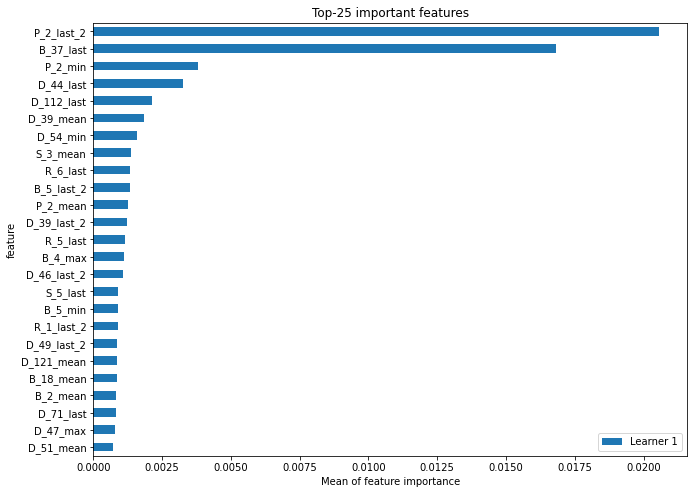

In [ ]:
# searching for the best algorithm with AutoML

automl = AutoML() 
automl.fit(X_train, pd.DataFrame(y_train))

In [ ]:
# Comparing the best model 

In [ ]:
# checking score with amex metric

def amex_metric(y_true, y_pred):
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
# making predict and check the final score

prediction = automl.predict_proba(X_val)

val_score = amex_metric(y_true=y_val.reshape(-1, ), y_pred=prediction[:, 1].reshape(-1, ).astype(np.float32))
val_score

0.7818777749075799

In [ ]:
#  tunning the best model to get the best score